# Hopland Dataset Analysis

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dnadb import fasta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from setbert.models import SetBertForSampleEmbedding
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

2025-07-29 13:19:02.738479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753813142.755796 1489438 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753813142.761044 1489438 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-29 13:19:02.779906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
sequences = fasta.FastaDb("/home/data2/deepdna/datasets/hopland/sequences.fasta.db")
mappings = sequences.mappings("/home/data2/deepdna/datasets/hopland/sequences.fasta.mapping.db")

## Sample Embeddings

In [5]:
rng = np.random.default_rng()

In [ ]:
model = SetBertForSampleEmbedding.from_pretrained("sirdavidludwig/setbert", revision="qiita-16s")
model = model.cuda().eval()

# Encode sequences in chunks of 128
model.config.sequence_encoder_chunk_size = 128

In [7]:
def collate(sequences):
    token_ids = [torch.tensor(model.sequence_encoder.tokenizer(e.sequence)) for e in sequences]
    max_length = max(len(s) for s in token_ids)
    token_ids = [F.pad(s, (0, max_length - len(s))) for s in token_ids]
    token_ids = torch.stack(token_ids)
    return token_ids

In [8]:
# embeddings = {}
# for mapping in tqdm(mappings):
#     name = mapping.name
#     sequences = collate(mapping.sample(1000, rng))
#     with torch.no_grad():
#         embeddings[name] = model(sequences.unsqueeze(0).cuda()).squeeze().cpu().numpy()

# import pickle
# with open("./hopland_embeddings.pkl", "wb") as f:
#     pickle.dump(embeddings, f)

In [9]:
import pickle
with open("./hopland_embeddings.pkl", "rb") as f:
    embeddings = pickle.load(f)

In [10]:
metadata = pd.DataFrame({
    "name": [m.name for m in mappings],
    "group": ["Bulk" if "-B-" in m.name else "Rhizosphere" for m in mappings]
})

In [11]:
from sklearn.manifold import MDS, TSNE

# Apply MDS and t-SNE and construct a Pandas table with x, y coordinates for each mode
mds = MDS(n_components=2, dissimilarity="euclidean", n_jobs=16)
tsne = TSNE(n_components=2, n_jobs=16)

mds_embeddings = mds.fit_transform(np.stack(list(embeddings.values())))
tsne_embeddings = tsne.fit_transform(np.stack(list(embeddings.values())))

df = pd.DataFrame({
    "name": list(embeddings.keys()),
    "group": metadata.set_index("name")["group"].values,
    "mds_x": mds_embeddings[:, 0],
    "mds_y": mds_embeddings[:, 1],
    "tsne_x": tsne_embeddings[:, 0],
    "tsne_y": tsne_embeddings[:, 1]
})

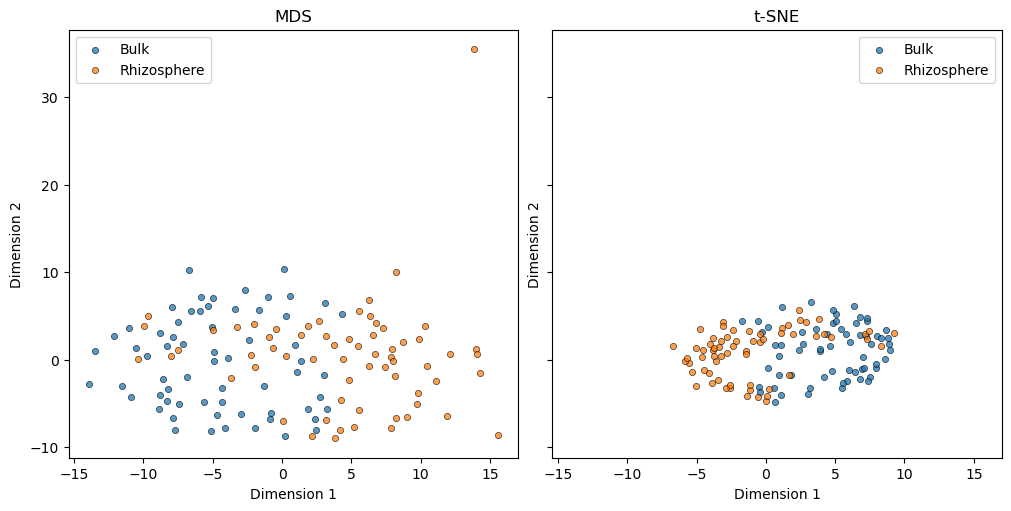

In [12]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True, layout="constrained")

for method, ax in zip(["mds", "tsne"], axs):
    for group in ["Bulk", "Rhizosphere"]:
        df_method = df[df["group"] == group]
        ax.scatter(
            df_method[f"{method}_x"],
            df_method[f"{method}_y"],
            label=group,
            s=20,
            alpha=0.75,
            # outline of each point
            linewidths=0.5,
            edgecolors="black"
        )
    ax.set_title("MDS" if method == "mds" else "t-SNE")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.legend()

fig.show()

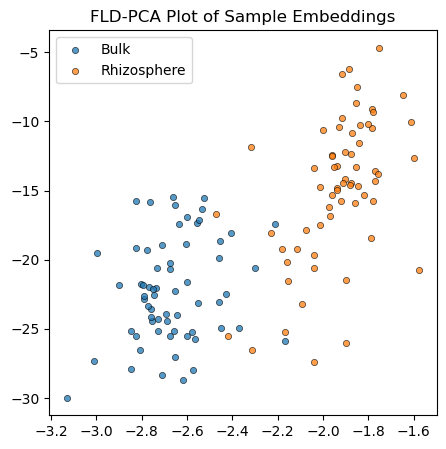

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

class LDAPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_orthogonal=1):
        self.n_orthogonal = n_orthogonal

    def fit(self, X, y):
        # 1. supervised axis
        lda = LinearDiscriminantAnalysis(n_components=1)
        self.w_ = lda.fit(X, y).scalings_[:, 0]
        self.w_ /= np.linalg.norm(self.w_)

        # 2. orthogonal PCA axes
        X_resid = X - np.outer(X @ self.w_, self.w_)
        pca = PCA(n_components=self.n_orthogonal)
        self.V_ = pca.fit(X_resid).components_
        return self

    def transform(self, X):
        proj_w = X @ self.w_
        X_resid = X - np.outer(proj_w, self.w_)
        proj_V = X_resid @ self.V_.T
        return np.column_stack([proj_w, proj_V])


X = np.stack(list(embeddings.values()))
y = metadata.set_index("name")["group"].values == "Rhizosphere"

embedder = LDAPCA(n_orthogonal=1)
embedder.fit(X, y)
Z = embedder.transform(X)

df = pd.DataFrame({
    "name": list(embeddings.keys()),
    "group": metadata.set_index("name")["group"].values,
    "fld_x": Z[:, 0],
    "fld_y": Z[:, 1]
})

# Plot

plt.figure(figsize=(5, 5))
plt.title("FLD-PCA Plot of Sample Embeddings")
for group in ["Bulk", "Rhizosphere"]:
    df_method = df[df["group"] == group]
    plt.scatter(
        df_method["fld_x"],
        df_method["fld_y"],
        label=group,
        s=20,
        alpha=0.75,
        linewidths=0.5,
        edgecolors="black"
    )
plt.legend()

## Attention Attribution

In [14]:
from dnadb import taxonomy

taxonomy_ranks = [r.lower() for r in taxonomy.RANKS][:6]

taxonomy_labels = {}
with open("/home/data2/deepdna/datasets/hopland/taxonomy.tsv") as f:
    f.readline()
    for line in f:
        sequence_id, label, _ = line.strip().split('\t')
        taxonomy_labels[sequence_id] = label

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class AnalyticLinearClassifier(nn.Module):
    def __init__(self, base_model: nn.Module):
        super().__init__()
        self.base_model = base_model
        self.classifier = None  # Will be initialized in fit()

    def fit(
        self,
        embeddings: torch.Tensor,  # shape (N, D)
        labels: torch.Tensor,      # shape (N,)
        num_classes: int,
        verbose: bool = False,
        max_iter: int = 1000,
        tol: float = 1e-6,
        device = "cpu",
    ):
        self.to(device)
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        self.classifier = nn.Linear(embeddings.shape[-1], num_classes, bias=False).to(device)

        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.LBFGS(self.classifier.parameters(), max_iter=max_iter, tolerance_grad=tol)

        def optimization_step():
            optimizer.zero_grad()
            logits = self.classifier(embeddings)
            loss = loss_fn(logits, labels)
            loss.backward()
            return loss

        loss = optimizer.step(optimization_step)
        if verbose:
            with torch.no_grad():
                preds = torch.argmax(self.classifier(embeddings), dim=1)
                acc = (preds == labels).float().mean().item() * 100
            print(f"Final loss: {loss.item():.6f}, Accuracy: {acc:.2f}%")
        return self

    def forward(self, *args, **kwargs):
        x = self.base_model(*args, **kwargs)
        if self.classifier is None:
            raise RuntimeError("You must call `fit()` before using the classifier.")
        return self.classifier(x)

In [16]:
X = np.stack([embeddings[row["name"]] for _, row in df.iterrows()])
y = (df["group"].values == "Rhizosphere").astype(int)

classifier = AnalyticLinearClassifier(model)
classifier = classifier.fit(torch.tensor(X), torch.tensor(y), 2, verbose=True).cuda().eval()

[LBFGS] Final loss: 1.196694, Accuracy: 100.00%


In [17]:
from explainable_attention import self_attention_attribution as saa
from tqdm import tqdm

def collate(sequences):
    sequence_ids = [e.identifier for e in sequences]
    token_ids = [torch.tensor(model.sequence_encoder.tokenizer(e.sequence)) for e in sequences]
    max_length = max(len(s) for s in token_ids)
    token_ids = [F.pad(s, (0, max_length - len(s))) for s in token_ids]
    token_ids = torch.stack(token_ids)
    return sequence_ids, token_ids

def objective(batch):
    x, y = batch
    y_pred = classifier(x)
    loss = nn.functional.cross_entropy(y_pred, y.long())
    return loss

scores_by_sample = {}
for sample in tqdm(embeddings):
    if sample not in scores_by_sample:
        scores_by_sample[sample] = {}

    # Sample sequences and construct the batch
    with torch.no_grad():
        sequence_ids, tokens = collate([m for m in mappings if m.name == sample][0].sample(1000, np.random.default_rng(0)))
        tokens = tokens.unsqueeze(0).cuda()
        batch = (
            classifier.base_model.embed_sequences(
                tokens,
                classifier.base_model.compute_padding_mask(sequence_tokens=tokens)
            ),
            torch.tensor([metadata[metadata["name"] == sample]["group"].values[0] == "Rhizosphere"]).cuda().int()
        )

    # Compute attention attribution
    attribution = saa.compute(
        classifier.base_model.transformer.layers,
        objective,
        batch,
        integration_steps=20,
        show_progress=False
    )
    classifier.zero_grad()

    # Compute the attention scores
    with torch.no_grad():
        attention = attribution.detach()[0].cuda()
        attention = torch.clamp(attention, 0.0, None)
        attention = torch.sum(attention, (0, 1, 2))[1:]
        attention = attention / (torch.max(attention) + 1e-8)
        attention = attention.cpu().numpy()

    for sequence_id, score in zip(sequence_ids, attention):
        if sequence_id not in scores_by_sample[sample]:
            scores_by_sample[sample][sequence_id] = {
                "abundance": 0,
                "score": 0.0
            }
        scores_by_sample[sample][sequence_id]["abundance"] += 1
        scores_by_sample[sample][sequence_id]["score"] += score.item()

    torch.cuda.empty_cache()

import pickle
with open("./hopland_scores", "wb") as f:
    pickle.dump(scores_by_sample, f)

/tmp/ipykernel_1489438/3050218686.py:25: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  sequence_ids, tokens = collate([m for m in mappings if m.name == sample][0].sample(1000, np.random.default_rng(0)))
/opt/conda/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  0%|          | 0/128 [00:03<?, ?it/s]

KeyboardInterrupt



/tmp/ipykernel_324345/3050218686.py:25: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  sequence_ids, tokens = collate([m for m in mappings if m.name == sample][0].sample(1000, np.random.default_rng(0)))
/opt/conda/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  5%|▌         | 7/128 [00:20<05:49,  2.89s/it]

In [18]:
import pickle
with open("./hopland_scores", "rb") as f:
    scores_by_sample = pickle.load(f)

In [38]:
scores_by_group = {
    "rhizosphere": {},
    "bulk": {}
}

for sample, sequences in scores_by_sample.items():
    # Ensure it's a rhizosphere score
    if metadata[metadata["name"] == sample]["group"].values[0] == "Bulk":
        group = "bulk"
    else:
        group = "rhizosphere"
    for sequence_id, score in sequences.items():
        if sequence_id not in scores_by_group[group]:
            ranks = taxonomy.split_taxonomy(taxonomy_labels[sequence_id], True)
            scores_by_group[group][sequence_id] = {
                **{rank: label for rank, label in zip(taxonomy_ranks, ranks)},
                "abundance": 0,
                "score": 0.0
            }
        scores_by_group[group][sequence_id]["abundance"] += score["abundance"]
        scores_by_group[group][sequence_id]["score"] += score["score"]

scores_by_group = {
    "rhizosphere": pd.DataFrame.from_dict(scores_by_group["rhizosphere"], orient="index"),
    "bulk": pd.DataFrame.from_dict(scores_by_group["bulk"], orient="index")
}

for group in scores_by_group:
    scores_by_group[group].to_csv(f"./{group}_scores.csv")

In [39]:
scores_by_group = {
    "rhizosphere": pd.read_csv("./rhizosphere_scores.csv", index_col=0),
    "bulk": pd.read_csv("./bulk_scores.csv", index_col=0)
}

### Control-abundance Shift

In [40]:
from typing import Dict, Optional, Tuple

def unify(*dataframes: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    # Step 1: Copy all input DataFrames
    dfs = [df.copy() for df in dataframes]

    print(len(dfs))

    # Step 2: Union of all sequence IDs
    all_ids = pd.Index([])
    for df in dfs:
        all_ids = all_ids.union(df.index)

    # Step 3: Reindex and fill missing abundance/score
    for i, df in enumerate(dfs):
        df = df.reindex(all_ids)
        df["abundance"] = df["abundance"].fillna(0)
        df["score"] = df["score"].fillna(0.0)
        dfs[i] = df

    # Step 4: Determine taxonomy ranks present
    taxonomy_ranks = []
    for rank in taxonomy.RANKS:
        if rank.lower() not in dfs[0].columns:
            break
        taxonomy_ranks.append(rank.lower())

    # Step 5: Fill in taxonomy columns from other DataFrames
    for col in taxonomy_ranks:
        # For each DataFrame, fill missing taxonomy values from the others
        for i in range(len(dfs)):
            for j in range(len(dfs)):
                if i != j:
                    dfs[i][col] = dfs[i][col].fillna(dfs[j][col])

    return tuple(dfs)


def group_by_taxonomy(df: pd.DataFrame, depth: Optional[str] = None):
    """
    Group the taxonomy dataframe by the taxonomy ranks. Sum abundance and score
    """
    taxonomy_ranks = []
    for rank in taxonomy.RANKS:
        if rank.lower() not in df.columns:
            break
        taxonomy_ranks.append(rank.lower())
        if depth is not None and rank.lower() == depth.lower():
            break
    all_ranks = [r.lower() for r in taxonomy.RANKS]
    value_cols = [col for col in df.columns if col not in all_ranks]
    return df.groupby(taxonomy_ranks)[value_cols].sum().reset_index()


def control_abundance_shift(src: pd.DataFrame, dest: pd.DataFrame):
    # Compute taxonomy ranks
    taxonomy_ranks = []
    for rank in taxonomy.RANKS:
        if rank.lower() not in src.columns:
            break
        taxonomy_ranks.append(rank.lower())

    # Ensure that src and dest have the same shape and share the same taxonomies
    assert src.shape[0] == dest.shape[0], "src and dest must have the same number of rows"
    assert src[taxonomy_ranks].equals(dest[taxonomy_ranks]), "src and dest must have the same taxonomies"

    src = src.copy()
    dest = dest.copy()

    # Step 1. Normalize abundance and scores
    src[["abundance", "score"]] = src[["abundance", "score"]] / src[["abundance", "score"]].sum()
    dest[["abundance", "score"]] = dest[["abundance", "score"]] / dest[["abundance", "score"]].sum()

    # Step 2. Compute the control abundance shift
    result = dest.copy()
    result["score_shift"] = (dest["score"] - src["score"] - dest["abundance"]).clip(lower=0.0)
    result["score_shift"] = result["score_shift"] / result["score_shift"].sum()

    return result

def merge(tax_dfs: Dict[str, pd.DataFrame]):
    # Compute taxonomy ranks
    ref_df = next(iter(tax_dfs.values()))
    taxonomy_ranks = []
    for rank in taxonomy.RANKS:
        if rank.lower() not in ref_df.columns:
            break
        taxonomy_ranks.append(rank.lower())

    # Ensure that each dataframe has the same taxonomy depth
    for rank in taxonomy_ranks:
        for name, df in tax_dfs.items():
            assert rank in df.columns, f"{name} is missing {rank}"

    # Merge the such that additional columns are prefixed with the dataframe's key
    result = pd.DataFrame(columns=taxonomy_ranks)
    for name, df in tax_dfs.items():
        df = df.copy()
        df.columns = [col if col in taxonomy_ranks else f"{name}_{col}" for col in df.columns]
        result = result.merge(df, on=taxonomy_ranks, how="outer", suffixes=("", ""))
    return result

In [42]:
# Step 1. Unify the dataframes by ensuring they share the same sequences
bulk, rhizosphere = unify(scores_by_group["bulk"], scores_by_group["rhizosphere"])

# Step 2. Aggregate by taxa
depth = "genus"
bulk = group_by_taxonomy(bulk, depth)
rhizosphere = group_by_taxonomy(rhizosphere, depth)

# Step 3. Compute the fine-grained control abundance shift
bulk = control_abundance_shift(rhizosphere, bulk)
rhizosphere = control_abundance_shift(bulk, rhizosphere)

# Step 4. Group by taxonomy to the desired depth
depth = "phylum"
bulk = group_by_taxonomy(bulk, depth)
rhizosphere = group_by_taxonomy(rhizosphere, depth)

# Step 5. Merge the dataframes
# df = merge({"bulk": bulk, "rhizosphere": rhizosphere})

2


/tmp/ipykernel_1489438/4302903.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("custom_40")
/opt/conda/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


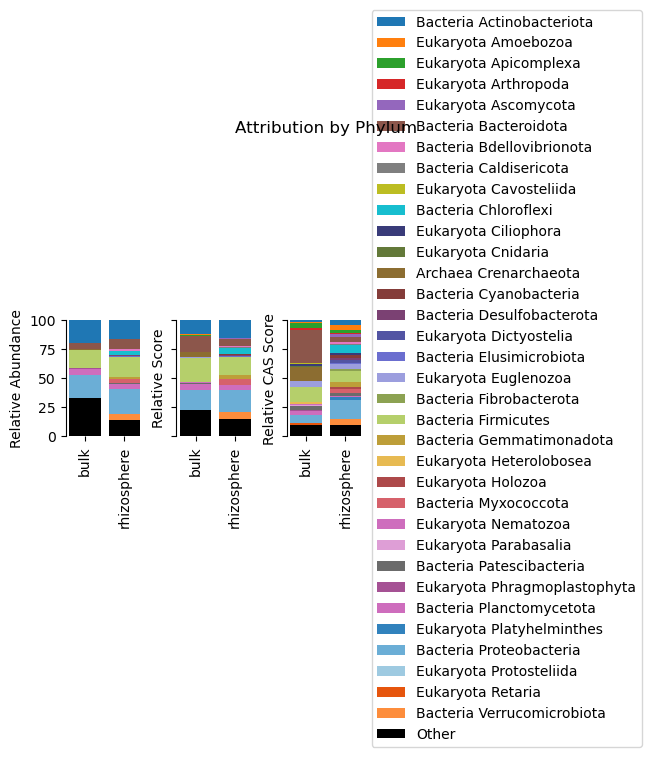

In [43]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# Define 40 visually distinct colors (RGB tuples)
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173",
    "#5254a3", "#6b6ecf", "#9c9ede", "#8ca252", "#b5cf6b",
    "#bd9e39", "#e7ba52", "#ad494a", "#d6616b", "#ce6dbd",
    "#de9ed6", "#6b6b6b", "#a55194", "#ce6dbd", "#3182bd",
    "#6baed6", "#9ecae1", "#e6550d", "#fd8d3c", "#fdae6b",
    "#31a354", "#74c476", "#a1d99b", "#756bb1", "#9e9ac8"
]

# Create a ListedColormap
cmap_40 = ListedColormap(colors, name="custom_40")

# Register the colormap (optional)
try:
    mpl.colormaps.register(name="custom_40", cmap=cmap_40)
except:
    pass


def relative_attribution_plot(
    dfs: Dict[str, pd.DataFrame],
    top: float = 0.9,
    show_score: bool = True,
    show_shift_score: bool = True,
    bar_width: float = 0.8,
    plot_width: float = 3,
    plot_height: float = 10
):
    # Compute taxonomy ranks
    ref_df = next(iter(dfs.values()))
    taxonomy_ranks = []
    for rank in taxonomy.RANKS:
        if rank.lower() not in ref_df.columns:
            break
        taxonomy_ranks.append(rank.lower())

    # Ensure that each dataframe has the same taxonomy depth
    for rank in taxonomy_ranks:
        for name, df in dfs.items():
            assert rank in df.columns, f"{name} is missing {rank}"

    # Check if we should use shift_score or score
    if show_shift_score:
        score_col = "score_shift"
        if not all(score_col in df.columns for df in dfs.values()):
            show_shift_score = False
    elif show_score and "score" in ref_df.columns:
        score_col = "score"
    else:
        raise ValueError("No score column found")

    # Compute the unified top taxa within each classification group
    top_taxa = {}
    for group, df in dfs.items():
        # Sort the dataframe by the score column
        df = df.sort_values(score_col, ascending=False)
        # Compute the cumulative score
        df["cumulative_score"] = df[score_col].cumsum()
        # Find the top taxa that make up 90% of the score.
        for _, row in df.iterrows():
            key = tuple(row[taxonomy_ranks])
            if key not in top_taxa:
                top_taxa[key] = {
                    "abundance": {},
                    "score": {},
                    "score_shift": {}
                }
            top_taxa[key]["abundance"][group] = row["abundance"]
            top_taxa[key]["score"][group] = row["score"]
            if "score_shift" in row:
                top_taxa[key]["score_shift"][group] = row["score_shift"]
            if row["cumulative_score"] >= top:
                break
    top_taxa = dict(sorted(top_taxa.items(), key=lambda x: x[0][-1]))

    # Create taxonomy bar plots by group
    num_plots = 1
    if show_score:
        num_plots += 1
    if show_shift_score:
        num_plots += 1
    width = bar_width*num_plots + plot_width
    fig, axs = plt.subplots(1, num_plots, figsize=(width, plot_height), sharey=True, layout="constrained")

    # Plot the relative abundance of each group
    labels = {
        "abundance": "Relative Abundance",
        "score": "Relative Score",
        "score_shift": "Relative CAS Score"
    }
    keys = ["abundance"]
    if show_score:
        keys.append("score")
    if show_shift_score:
        keys.append("score_shift")
    color_map = plt.cm.get_cmap("custom_40")
    for key, ax in zip(keys, axs):
        values = 100.0*np.array([[d[key].get(group, 0.0) for group in dfs] for d in top_taxa.values()])
        bottoms = 100.0
        for i, tax in enumerate(top_taxa):
            bottoms = bottoms - values[i]
            ax.bar(
                np.arange(values.shape[1]),
                values[i],
                bottom=bottoms,
                label=" ".join(tax),
                width=bar_width,
                color=color_map(i)
            )
        ax.bar(
            np.arange(values.shape[1]),
            bottoms,
            label="Other",
            width=bar_width,
            color="black"
        )
        ax.set_ylabel(labels[key])
        ax.set_xticks(np.arange(values.shape[1]))
        ax.set_xticklabels(dfs.keys(), rotation=90)
        ax.set_ylim((0, 100))
        # remove all but left spines
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
    fig.suptitle(f"Attribution by {taxonomy_ranks[-1].title()}")
    fig.show()

relative_attribution_plot(
    {"bulk": bulk, "rhizosphere": rhizosphere},
    top=0.9,
    show_score=True,
    show_shift_score=True,
    bar_width=0.8,
    plot_width=4,
    plot_height=5
)